In [8]:
import numpy as np
import matplotlib.pyplot as plt

class VelocityField:
    def __init__(self, grid_size, N, l, sigma, u_mean, x_min, x_max, y_min, y_max):
        self.grid_size = grid_size
        self.N = N  # number of modes
        self.l = l  # correlation length scale
        self.sigma = sigma  # scaling factor for random velocities
        self.u_mean = u_mean  # magnitude of mean velocity

        # Grid definition for velocity field, using the passed x and y ranges
        self.x = np.linspace(x_min, x_max, grid_size)
        self.y = np.linspace(y_min, y_max, grid_size)
        self.X, self.Y = np.meshgrid(self.x, self.y)

        # Velocity field variables will be initialized to None
        self.U = None
        self.V = None

    def generate_velocity_field(self):
        """
        Generates the 2D Gaussian random velocity field only when explicitly called.
        """
        U = np.zeros_like(self.X)
        V = np.zeros_like(self.Y)

        # Generate random wave vectors and phases
        k_vectors = self.generate_random_k()
        phases = self.generate_random_phi()

        for j in range(self.N):
            k_dot_x = k_vectors[j, 0] * self.X + k_vectors[j, 1] * self.Y  # dot product of k^(j) and x
            cos_term = np.cos(k_dot_x + phases[j])

            # Compute projection p_i(k^(j)) for each velocity component
            p = self.compute_p(k_vectors[j])

            # Contribution to velocity components
            U += p[0] * cos_term
            V += p[1] * cos_term

        # Scaling and adding mean velocity
        U = self.u_mean - self.sigma * self.u_mean * np.sqrt(2 / self.N) * U
        V = -self.sigma * self.u_mean * np.sqrt(2 / self.N) * V

        # Store generated fields in self.U and self.V
        self.U = U
        self.V = V

    def generate_random_k(self):
        """
        Generate random vectors k^(j) from a 2D Gaussian distribution.
        """
        return np.random.normal(0, 1 / self.l, (self.N, 2))

    def generate_random_phi(self):
        """
        Generate random phases φ^(j) uniformly in [0, 2π].
        """
        return np.random.uniform(0, 2 * np.pi, self.N)

    def compute_p(self, k_vector):
        """
        Compute the projection p_i(k^(j)) for each velocity component.
        """
        k1 = k_vector[0]
        k2 = k_vector[1]
        k_square = k1 ** 2 + k2 ** 2
        if k_square == 0:  # Avoid division by zero
            return np.array([0, 0])
        else:
            return np.array([1 - (k1 * k1) / k_square, -(k1 * k2) / k_square])

    def get_velocity(self, position):
        """
        Interpolate the velocity at a given position. Ensure the velocity field has been generated.
        """
        if self.U is None or self.V is None:
            raise ValueError("Velocity field has not been generated. Call generate_velocity_field() first.")
        
        x_idx = np.abs(self.X[0, :] - position[0]).argmin()
        y_idx = np.abs(self.Y[:, 0] - position[1]).argmin()
        velocity = np.array([self.U[y_idx, x_idx], self.V[y_idx, x_idx]])
        return velocity

class Particle:
    def __init__(self, initial_position, time):
        self.position = [np.array(initial_position)]  # Initialize position list (2D)
        self.time = time
        self.is_outside = False  # Initialize whether the particle is outside the domain

    def update_position(self, velocity_field, simulation):
        # Stop updating if the particle is already outside
        if self.is_outside:
            return

        # Apply the extended Runge-Kutta method to update particle position
        x_intermediate = np.zeros((3, 2))
        epsilon_intermediate = np.zeros((3, 2))
        mu_intermediate = np.zeros((3, 2))

        # Get the last recorded position
        last_position = self.position[-1]

        # Generate noise for all intermediate steps
        for i in range(3):
            epsilon_intermediate[i, :] = simulation.generate_noise()

        # Compute intermediate steps using the Extended Runge-Kutta method
        for i in range(3):
            if i == 0:
                mu_intermediate[i, :] = velocity_field.get_velocity(last_position) * simulation.dt
            else:
                mu_intermediate[i, :] = velocity_field.get_velocity(x_intermediate[i - 1, :]) * simulation.dt

            for j in range(i + 1):
                x_intermediate[i, :] += (
                    simulation.alpha[i, j] * mu_intermediate[j, :]
                    + simulation.beta[i, j] * epsilon_intermediate[j, :]
                )

            x_intermediate[i, :] += last_position

        # Final update of the position
        new_position = x_intermediate[-1]        

        # Check if the particle is outside the grid and update the is_outside flag
        if not self.check_if_outside(velocity_field):
            # Append the new position and time to the respective lists
            self.position.append(new_position)

    def check_if_outside(self, velocity_field):
        # Calculate the boundaries from velocity_field's x and y attributes
        x_min, x_max = velocity_field.x[0], velocity_field.x[-1]
        y_min, y_max = velocity_field.y[0], velocity_field.y[-1]

        # Get the last recorded position
        last_position = self.position[-1]

        # Check if the particle is outside the defined boundaries
        if not (x_min <= last_position[0] <= x_max and y_min <= last_position[1] <= y_max):
            self.is_outside = True
            return True

class Simulation:
    def __init__(self, D, time, initial_positions, num_vf_realization, num_noise_realization, dt=None):
        self.D = D  # Diffusion coefficient
        self.time = np.array(time)
        self.initial_positions = np.array(initial_positions)
        self.num_time_step = len(self.time)
        self.num_particle = self.initial_positions.shape[0]
        self.num_vf_realization = num_vf_realization
        self.num_noise_realization = num_noise_realization
        self.vf_realization_data = None
        self.alpha = np.array([
                [0.66275881, 0.,         0.        ],
                [0.00733232, 0.66311191, 0.        ],
                [0.24997509, 0.37079131, 0.37923354]
            ])  # Runge-Kutta alpha coefficients
        self.beta = np.array([
                [0.81410000, 0.,          0.        ],
                [0.81410000, -0.08766369, 0.        ],
                [0.81410000, -0.08766369, 0.57406991]
            ])  # Runge-Kutta beta coefficients
            
        if dt is None:
            self.dt = self.average_spacing(self.time)
        else:
            self.dt = dt

    def average_spacing(self, x):
        x_len = len(x)
        if x_len % 2 == 0:
            mid_idx = int(x_len / 2)
            return np.sum((x[mid_idx:] - x[:mid_idx])) / (x_len ** 2 / 4)
        else:
            mid_idx = int((x_len - 1) / 2)
            return np.sum((x[mid_idx:] - x[:mid_idx+1])) / ((x_len ** 2 - 1) / 4)

    def generate_noise(self):
        # Generate Gaussian white noise
        return np.sqrt(2 * self.D * self.dt) * np.random.normal(0, 1, 2)

    def run_simulation(self, velocity_field):
        """
        Run simulations over multiple velocity fields (ensemble realizations)
        and multiple noise realizations for each field.

        :param velocity_field: List of VelocityField instances
        """
        vf_realization_data = []  # List to hold data for each velocity field

        for vf_idx in range(self.num_vf_realization):
            # New velocity field realization
            velocity_field.generate_velocity_field()

            particle_realization_data = [] # List to hold data for each particle

            for p_idx in range(self.num_particle):
                # Initialize copies of a particle
                particles = [Particle(initial_position=self.initial_positions[p_idx], time=self.time) for _ in range(self.num_noise_realization)]

                # Run simulation for all noise realization
                for t_idx in range(1, len(self.time)):
                    for particle in particles:
                        particle.update_position(velocity_field, self)

                # Store the positions
                positions = np.zeros((self.num_noise_realization, len(self.time), 2))
                for noise_idx, particle in enumerate(particles):
                    positions[noise_idx, :len(particle.position)] = np.array(particle.position)

                particle_realization_data.append(positions)

            vf_realization_data.append(particle_realization_data)

        self.vf_realization_data = np.array(vf_realization_data)

        return self.vf_realization_data

    def calculate_dispersion_coefficients(self):
        """
        Calculate D_{ii}^{eff}(t) and D_{ii}^{ens}(t) using the collected ensemble data.

        :param self.vf_realization_data: Data collected from run_simulation method
        :return: time, D_ii_eff, D_ii_ens
        """

        # # Compute the noise averages
        # xi_t_noise_avg = np.mean(self.vf_realization_data, axis=2)
        # xi_square_t_noise_avg = np.mean(self.vf_realization_data ** 2, axis=2)

        # # Compute velocity field averages 
        # xi_t_noise_avg_vf_avg = np.mean(xi_t_noise_avg, axis=0)  # Shape: [self.num_time_step, 2]
        # xi_square_t_noise_avg_vf_avg = np.mean(xi_square_t_noise_avg, axis=0)  # Shape: [self.num_time_step, 2]
        # xi_t_noise_avg_square_vf_avg = np.mean(xi_t_noise_avg ** 2, axis=0)  # Shape: [time, x/y]

        # # Compute the quantities inside the derivative
        # D_ii_eff_numerator = xi_square_t_noise_avg_vf_avg - xi_t_noise_avg_square_vf_avg  # Shape: [time, x/y]
        # D_ii_ens_numerator = xi_square_t_noise_avg_vf_avg - xi_t_noise_avg_vf_avg ** 2  # Shape: [time, x/y]

        # # Compute the time derivatives using finite differences
        # D_ii_eff = np.zeros((self.num_particle, self.num_time_step - 1, 2))
        # D_ii_ens = np.zeros((self.num_particle, self.num_time_step - 1, 2))

        # Noise avg, particle avg, velocity avg
        xi_navg = np.mean(self.vf_realization_data, axis=2)
        xi_navg_pavg = np.mean(xi_navg, axis=1)
        xi_navg_pavg_vavg = np.mean(xi_navg_pavg, axis=0)

        xi_navg_sq = xi_navg ** 2
        xi_navg_pavg_sq = xi_navg_pavg ** 2
        xi_navg_sq_pavg = np.mean(xi_navg_sq, axis=1)
        xi_navg_pavg_vavg_sq = xi_navg_pavg_vavg ** 2
        xi_navg_pavg_sq_vavg = np.mean(xi_navg_pavg_sq, axis=0)

        S_ii = np.mean(xi_navg_sq_pavg - xi_navg_pavg_sq, axis=0)
        R_ii = xi_navg_pavg_sq_vavg - xi_navg_pavg_vavg_sq

        # Compute the time derivatives using finite differences
        D_ii_eff = np.zeros((self.num_time_step - 1, 2))
        D_ii_ens = np.zeros((self.num_time_step - 1, 2))
        print(S_ii.shape)

        for t_idx in range(1, self.num_time_step):
            D_ii_eff[t_idx - 1] = 0.5 * (S_ii[t_idx] - S_ii[t_idx - 1]) / self.dt
            D_ii_ens[t_idx - 1] = 0.5 * (R_ii[t_idx] - R_ii[t_idx - 1]) / self.dt

        # Return time series excluding initial time (since derivative is not defined at t=0)
        time = self.time[1:]
        return time, D_ii_eff, D_ii_ens

In [137]:
# Parameters for the simulation

l = 10 # correlation length in meters
Pe = 1000 # Peclet number
sigma = 1
tau_u = 1 # in seconds
dtau = 0.5
tau = np.arange(0, 100, dtau)

x_range = np.array([0, 140]) * l
y_range = np.array([0, 20]) * l
grid_size = 1000
N = 1000

time = tau_u * tau
dt = dtau * tau_u
u_mean = l / tau_u
D = u_mean * l / Pe
tau_D = l ** 2 / D

print(u_mean, 1 /tau_u)

num_particle = 200
num_vf_realization = 2000
num_noise_realization = 1

x_range_particle = np.array([1, 5]) * l
y_range_particle = np.array([6, 14]) * l

initial_positions = np.hstack((np.random.uniform(x_range_particle[0], x_range_particle[1], (num_particle, 1)), np.random.uniform(y_range_particle[0], y_range_particle[1], (num_particle, 1))))

print(u_mean, D, (x_range[-1]-x_range[0])/u_mean/tau_u, tau_D/tau_u)

10.0 1.0
10.0 0.1 140.0 1000.0


In [138]:
# Initialize the simulation
simulation = Simulation(D=D, time=time, initial_positions=initial_positions, num_vf_realization=num_vf_realization, num_noise_realization=num_noise_realization, dt=dt)

# Create an instance of the VelocityField class
velocity_field = VelocityField(grid_size=grid_size, N=N, l=l, sigma=sigma, u_mean=u_mean, x_min=x_range[0], x_max=x_range[1], y_min=y_range[0], y_max=y_range[1])

# Generate random velocity field
velocity_field.generate_velocity_field()

# Create multiple particle instances with random initial positions
particles = [Particle(initial_position=initial_positions[i], time=time) for i in range(num_particle)]

# Time integration loop for all particles
for t in range(simulation.num_time_step):
    for particle in particles:
        particle.update_position(velocity_field, simulation)


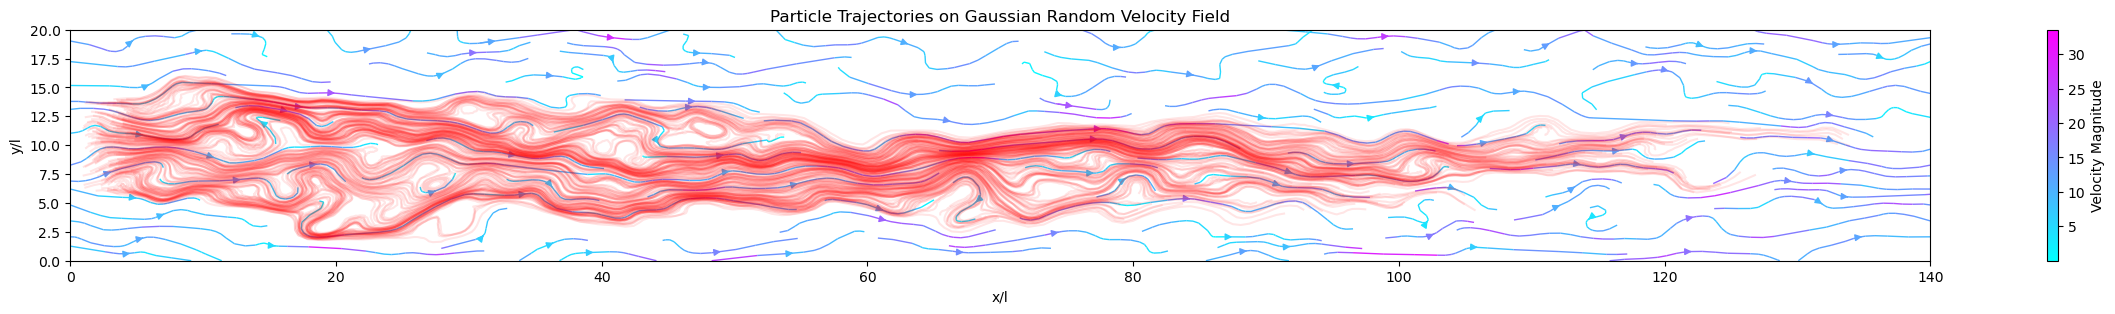

In [139]:
# Visualization: plot the velocity field and particle trajectories
plt.figure(figsize=(30, 3))

# Plot the velocity field as a stream plot
plt.streamplot(velocity_field.X / l, velocity_field.Y / l, velocity_field.U, velocity_field.V, color=np.sqrt(velocity_field.U**2 + velocity_field.V**2), cmap='cool', linewidth=1)

# Plot each particle's trajectory
for particle in particles:
    positions = np.array(particle.position)  # Convert list to NumPy array for easy slicing
    plt.plot(positions[:, 0] / l, positions[:, 1] / l, color='red', alpha=0.1, label="Particle Trajectories")

# Add labels and title
plt.title('Particle Trajectories on Gaussian Random Velocity Field')
plt.xlabel('x/l')
plt.ylabel('y/l')

# Display the plot
plt.colorbar(label='Velocity Magnitude')
plt.show()


(200, 2)


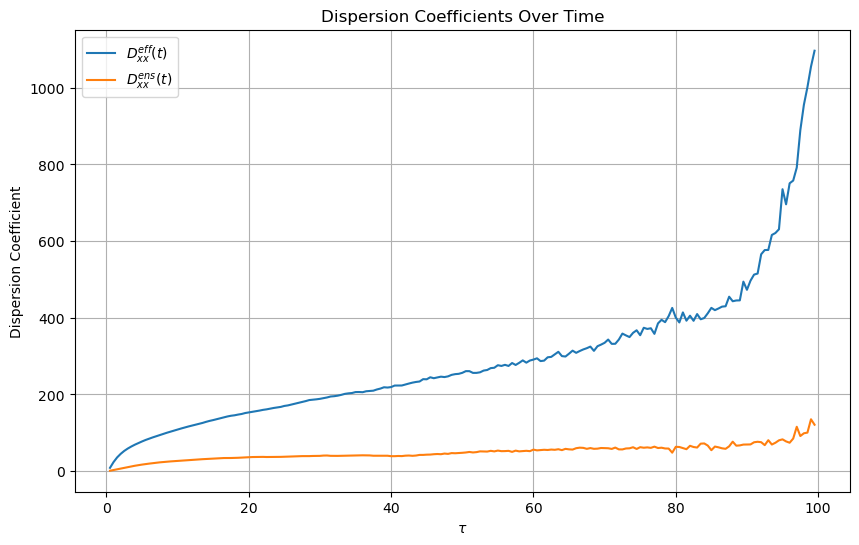

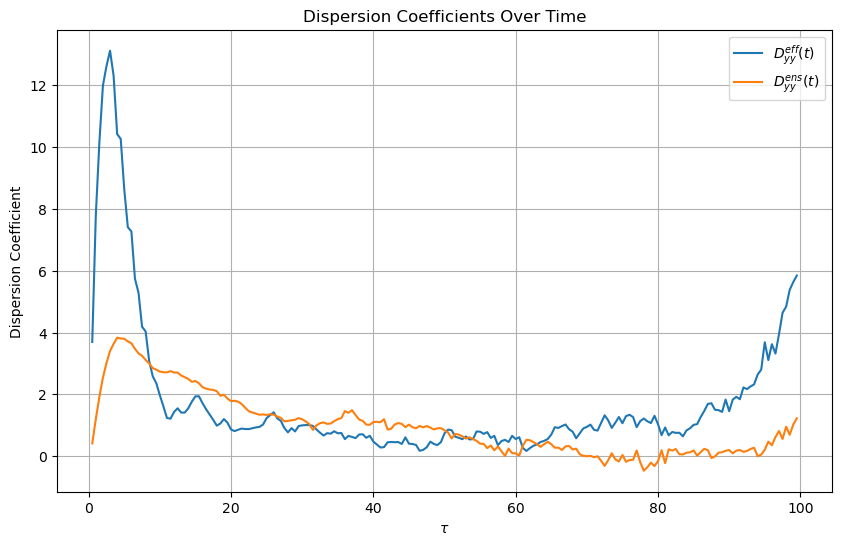

In [127]:
# Initialize the simulation
simulation = Simulation(D=D, time=time, initial_positions=initial_positions, num_vf_realization=num_vf_realization, num_noise_realization=num_noise_realization, dt=dt)

velocity_field = VelocityField(grid_size=grid_size, N=N, l=l, sigma=sigma, u_mean=u_mean, x_min=x_range[0], x_max=x_range[1], y_min=y_range[0], y_max=y_range[1])

vf_realization_data = simulation.run_simulation(velocity_field)

time, D_ii_eff, D_ii_ens = simulation.calculate_dispersion_coefficients()

# For the x-component (i=0)
plt.figure(figsize=(10, 6))
plt.plot(time/tau_u, D_ii_eff[:, 0], label='$D_{xx}^{eff}(t)$')
plt.plot(time/tau_u, D_ii_ens[:, 0], label='$D_{xx}^{ens}(t)$')
plt.xlabel('$\\tau$')
plt.ylabel('Dispersion Coefficient')
plt.title('Dispersion Coefficients Over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time/tau_u, D_ii_eff[:, 1], label='$D_{yy}^{eff}(t)$')
plt.plot(time/tau_u, D_ii_ens[:, 1], label='$D_{yy}^{ens}(t)$')
plt.xlabel('$\\tau$')
plt.ylabel('Dispersion Coefficient')
plt.title('Dispersion Coefficients Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
np.save('vf_realization_data_.npy', vf_realization_data, simulation)